In [2]:
!pip install CFEDemands --upgrade --pre
!pip install xarray --upgrade
!pip install h5netcdf

  Using cached https://files.pythonhosted.org/packages/bb/88/c089541197d01bdc33bdb517656e6d3780632d3443fdc4acc2c934ae09c5/CFEDemands-0.2.7.dev0-py2.py3-none-any.whl
You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/ee/11/fb2a8a6015e3de4ff19a4870bb0d11f48ebdd997062557d24cd076b3088f/xarray-0.15.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bb/71/8f53bdbcbc67c912b888b40def255767e475402e9df64050019149b1a943/pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a0/df/635cdb901ee4a8a42ec68e480c49f85f4c59e8816effbf57d9e6ee8b3588/setuptools-46.1.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3d/fc/4763e5f17ac6e7e7d55f377cde859ca1c5d5ac624441ab45315bc578aa9e/numpy-1.18.3-cp36-cp36m-manylinux1_x86_64.whl
Requirement already up-to-date: pytz>=2017.2

In [5]:
import cfe

# Results can be made persistent by saving them, and then re-loading...
r = cfe.from_dataset('./Ethiopia_small.ds')

r['alpha'] = r.alpha.loc[r.alpha>0]

In [6]:
r.prices.coords

Coordinates:
  * i        (i) object 'Banana' 'Barley' 'Beef' ... 'Tella' 'Tomato' 'Wheat'
  * t        (t) int64 2011 2013 2015
  * m        (m) int64 1
  * u        (u) object '40' 'Araba' ... 'Zorba/Akara \xa0  Small'

In [8]:
t = r.firstround  # First round
m = r.coords['m'][0] # First market

# Get median budget
x = r.get_predicted_expenditures().sum('i')
medianx = x.where(x>0).sel(t=t,m=m).median('j').values

# Note selection of prices for first market in first period for /kgs/.
# For goods never measured in kgs prices will be missing. 
p = r.prices.sel(t=2011,m=1,u='Kg',drop=True).to_dataframe().squeeze().dropna()
p

/srv/app/venv/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/app/venv/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


i
Banana            2.138573
Barley           10.130627
Chat / Kat        4.360239
Cheese           38.000000
Chick Pea        19.950864
Coffee            0.182123
Eggs             17.000000
Haricot Beans     8.400000
Horsebeans       11.201397
Kocho             3.872905
Lentils          25.350303
Linseed           0.249102
Maize             1.606267
Meat              9.164968
Milk             16.000000
Millet            5.986486
Onion             1.899735
Potato            2.128150
Salt              0.028861
Sorghum           3.867222
Sugar             0.269821
Teff              6.893324
Wheat             7.693904
Name: prices, dtype: float64

In [9]:
# Expenditures divided by reference prices per Kilogram
c=(r.demands(medianx)/p).dropna()
c

i
Banana            2.252682
Barley            7.575711
Chat / Kat        3.188113
Chick Pea         1.389511
Coffee           33.331246
Eggs              0.160435
Haricot Beans     1.785131
Horsebeans        1.725570
Lentils           0.273692
Maize            21.901694
Milk              0.348218
Onion             2.194407
Potato            1.472625
Salt             68.543013
Sorghum          29.018355
Sugar            30.475477
Teff              1.963178
Wheat            12.618170
dtype: float64

In [10]:
import pandas as pd
import numpy as np

# The function below adapted from Gianmario Spacagna's suggestion at
# https://stackoverflow.com/questions/19611729/getting-google-spreadsheet-csv-into-a-pandas-dataframe
def dataframe_from_gspreadsheet(sheet_name, key):
    """Transform public google spreadsheet into pandas.DataFrame."""
    
    url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
        key=key, sheet_name=sheet_name.replace(' ', '%20'))

    df = pd.read_csv(url)

    return df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

# Change 'ICRISAT' sheet id to that of your own sheet
fct = dataframe_from_gspreadsheet("Sheet2", '1fLm7yQYfkim7REWb0wkU33XMr2lcHvFG4-N782wiYlI')
# fct = dataframe_from_gspreadsheet("FCT", '1qUqZA8WELSvir4jM_2QkFg6vAatWeNW5mlJkIXlIshk')
#https://docs.google.com/spreadsheets/d/1fLm7yQYfkim7REWb0wkU33XMr2lcHvFG4-N782wiYlI/edit?usp=sharing

# Change some labels
d={'protein':'Protein',
   'protein g':'Protein',
   'fat':'Fat',
   'energy_kcal':'Calories',
   'energy kcal':'Calories',
   'calcium':'Calcium',
   'ca mg':'Calcium',
   'betacarotene':'Betacarotene',
   'thiamine':'Thiamine',
   'riboflavin':'Riboflavin',
   'niacin':'Niacin',
   'iron':'Iron',
   'fe mg':'Iron',
   'ascorbic_total':'Ascorbic Acid',
   'vit a ug':'Vitamin A',
   'vit b6 mg':'Vitamin B6',
   'vit b12 ug':'Vitamin B12',
   'vit d ug':'Vitamin D',
   'vit e ug':'Vitamin E',
   'vit c mg':'Vitamin C',
   'mg mg':'Magnesium',
   'zn mg':'Zinc'}

fct = fct.rename(columns=d) #[list(d.values())]

# Fix capitalization (to match food labels)
fct.index = fct.reset_index()['i'].str.title()
del fct['i']
del fct['ext_source']

# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('u')
except (AttributeError,KeyError):
    pass # No units?

fct.columns

Index(['Protein', 'Fat', 'fibre', 'carbohydrate', 'Calories', 'energy_kj',
       'Calcium', 'Iron', 'Betacarotene', 'caroten_total', 'Thiamine',
       'Riboflavin', 'Niacin', 'Ascorbic Acid', 'pu_cal', 'pu_prot', 'pu_fat'],
      dtype='object')

In [11]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(c,axis=0,join='inner')
print(fct0.index)

Index(['Milk', 'Sugar', 'Eggs', 'Potato', 'Onion', 'Banana', 'Coffee'], dtype='object', name='i')


In [12]:
# The @ operator means matrix multiply
N = fct0.T@c0
N

Protein             634.142940
Fat                4902.666234
fibre               100.490303
carbohydrate      26439.898224
Calories         110646.329262
energy_kj        463254.062004
Calcium           33787.353995
Iron               1428.974919
Betacarotene      39777.162072
caroten_total     74271.098254
Thiamine             14.161777
Riboflavin            4.138775
Niacin               27.524530
Ascorbic Acid       474.512385
pu_cal           125882.173552
pu_prot             131.534006
pu_fat               32.668108
dtype: float64

In [17]:
def nutrient_demand(x,pscale=None,p=p):
    c = (r.demands(x,p=pscale)/p).dropna()
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

Text(0, 0.5, 'log nutrient')

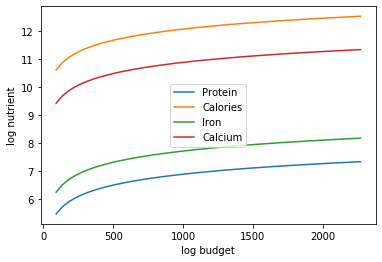

In [20]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(medianx/5,medianx*5,50).tolist()

UseNutrients = ['Protein','Calories','Iron','Calcium']

# Use reference prices
logN={}
for myx in X:
    logN[myx] = np.log(nutrient_demand(myx)[UseNutrients])
    
logN = pd.concat(logN,axis=1).T

plt.plot(X,logN)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

Text(0.5, 0, 'log Nutrient')

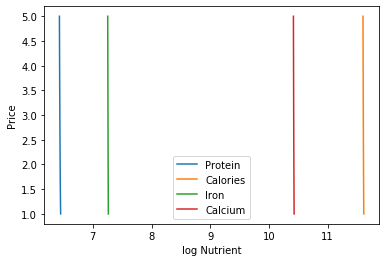

In [23]:
# Choose some good from your dataset
USE_GOOD = 'Potato'

P = np.linspace(1,5,20).tolist()

plt.plot(pd.concat({p0:np.log(nutrient_demand(medianx,pscale={USE_GOOD:p0})[UseNutrients]) for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log Nutrient')